In [1]:
import json
import os
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

C:\Users\29400\anaconda3\envs\ecs260\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 函数

In [4]:
def calculate_commits_freq(commits):
    if isinstance(commits, list):
        return len(commits)
    else:
        return 0


def calculate_releases_freq(releases):
    if isinstance(releases, list):
        return len(releases)
    else:
        return 0


def calculate_readme_size(readme):
    if isinstance(readme, str):
        return len(readme)
    else:
        return 0


def calculate_lines_of_codes(languages):
    if isinstance(languages, dict):
        return sum(languages.values())
    return 0


def calculate_popularity_score_1(stars, forks, pull_requests):
    return stars + forks + pull_requests * pull_requests


def calculate_popularity_score_2(watchers, pull_requests):
    return watchers + pull_requests * pull_requests


def calculate_popularity_score_3(stars, forks):
    return stars + forks

def classify_topics(topics):
    if topics is None or topics is [] or len(topics) == 0:
        return "unknown"
    model = SentenceTransformer('all-MiniLM-L6-v2')
    candidate_labels = ["operating system", "networking", "cybersecurity", "software development", "web", "AI", "database", "documentation", "programming language"]
    topic_embeddings = model.encode(topics)
    label_embeddings = model.encode(candidate_labels)

    # 计算 topic 向量与 candidate label 向量的余弦相似度
    similarities = util.pytorch_cos_sim(topic_embeddings, label_embeddings)

    # 找到每个 topic 的最佳匹配类别
    best_labels = [candidate_labels[idx] for idx in similarities.argmax(dim=1)]

    # 选择出现最多的分类作为最终分类
    return max(set(best_labels), key=best_labels.count)


def detect_and_remove_outliers(df, feature_columns):
    df = df.copy()  # Avoid modifying the original DataFrame

    for col in feature_columns:
        print(col)
        # Drop NaN values for this column
        df = df.dropna(subset=[col])

        # Calculate IQR bounds
        Q1 = np.percentile(df[col], 25)  # First quartile (25%)
        Q3 = np.percentile(df[col], 75)  # Third quartile (75%)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR  # Lower bound
        upper_bound = Q3 + 1.5 * IQR  # Upper bound

        # Create a flag column indicating whether a sample is an outlier
        df[f"{col}_outlier_flag"] = ((df[col] >= lower_bound) & (df[col] <= upper_bound)).astype(int)

        # Plot distributions before and after cleaning
        plot_distribution(df[col], f"Original {col} Distribution", f"original_{col}_distribution.png")
        plot_distribution(df[df[f"{col}_outlier_flag"] == 1][col],
                               f"Cleaned {col} Distribution",
                               f"cleaned_{col}_distribution.png")

    # Remove rows where at least one outlier flag is 0 (outlier detected in any feature)
    outlier_flags = [f"{col}_outlier_flag" for col in feature_columns]
    df_cleaned = df[df[outlier_flags].all(axis=1)].copy()

    print(f"Original data size: {len(df)}")
    print(f"Cleaned data size: {len(df_cleaned)}")

    return df_cleaned, df


def plot_distribution(data, title, filename):
    """
    Plots the KDE distribution of a feature and saves it as a PNG file.

    Args:
    - data (pd.Series): The feature data.
    - title (str): Title of the plot.
    - filename (str): File path to save the image.
    """
    kde = gaussian_kde(data)
    x_values = np.linspace(data.min(), data.max(), 200)
    y_values = kde(x_values) * len(data)  # Scale KDE to count

    plt.figure(figsize=(8, 6))
    plt.plot(x_values, y_values, label=title, color="blue")
    plt.fill_between(x_values, y_values, alpha=0.3, color="blue")

    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True)
    plt.legend()

    # Save the plot
    # plt.savefig(filename, dpi=300)
    plt.show()


# 获取所有文件名

In [5]:
tqdm.pandas()
file_paths = []
for f_name in os.listdir('data'):
    if f_name.endswith('json'):
        file_paths.append("data/" + f_name)

print(f"Total files detected: {len(file_paths)}")

Total files detected: 185876


# 读取文件并创建Pandas Dataframe

In [6]:
error_count = 0
rows = []

for file_path in file_paths:
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            pull_requests = data.get("pull_requests", 0)  # 提取 pull_requests

            for url, details in data.items():
                if url != "pull_requests":  # 排除 pull_requests 键
                    row = {"url": url, "name": url.split('/')[-1], "owner": url.split('/')[-2]}
                    row.update(details)
                    row["pull_requests"] = pull_requests  # 添加 pull_requests 到每行数据中
                    rows.append(row)
    except Exception as e:
        error_count += 1

df = pd.DataFrame(rows)
print(f"Total errors: {error_count}")
print(f"Raw data size {len(df)}")

Total errors: 0
Raw data size 185876


# 新增readme_size，lines_of_codes，popularity_score_1(star + fork + pr^2)，popularity_score_2(watcher + pr^2)和popularity_score_3(star + fork)标签

In [7]:
df["readme_size"] = df["readme"].apply(calculate_readme_size)
df["commits_freq"] = df["commits"].apply(calculate_commits_freq)
df["releases_freq"] = df["releases"].apply(calculate_releases_freq)
df["lines_of_codes"] = df["languages"].apply(calculate_lines_of_codes)
df["popularity_score_1"] = df.apply(lambda row: calculate_popularity_score_1(row["stars"], row["forks"], row["pull_requests"]), axis=1)
df["popularity_score_2"] = df.apply(lambda row: calculate_popularity_score_2(row["watchers"], row["pull_requests"]), axis=1)
df["popularity_score_3"] = df.apply(lambda row: calculate_popularity_score_3(row["stars"], row["forks"]), axis=1)
print(f"Column names are: {list(df.columns)}")

Column names are: ['url', 'name', 'owner', 'forks', 'watchers', 'stars', 'languages', 'commits', 'creation_date', 'contributors', 'topics', 'subscribers', 'readme', 'releases', 'pull_requests', 'readme_size', 'commits_freq', 'releases_freq', 'lines_of_codes', 'popularity_score_1', 'popularity_score_2', 'popularity_score_3']


# 统计语言种类

In [8]:
languages = []
for repo_languages in df["languages"]:
    if isinstance(repo_languages, dict):  # 确保 repo_languages 是字典类型
        for repo_language in repo_languages:
            if repo_language not in languages:
                languages.append(repo_language)
print(f"There are total {len(languages)} languages")

There are total 541 languages


# 数据清理

forks


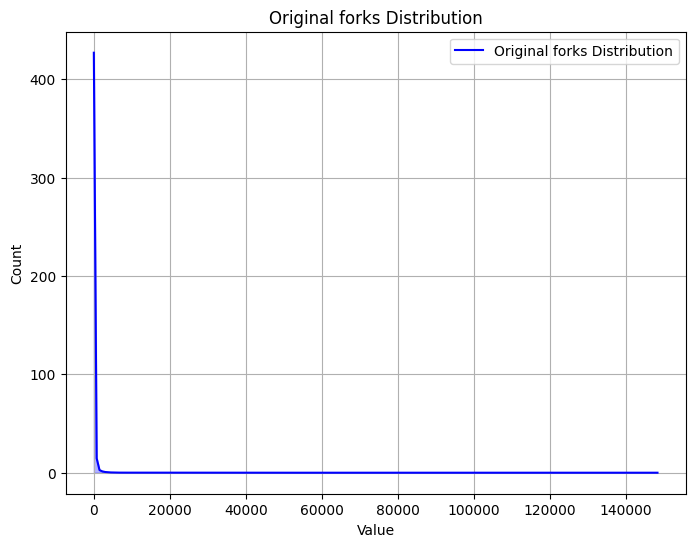

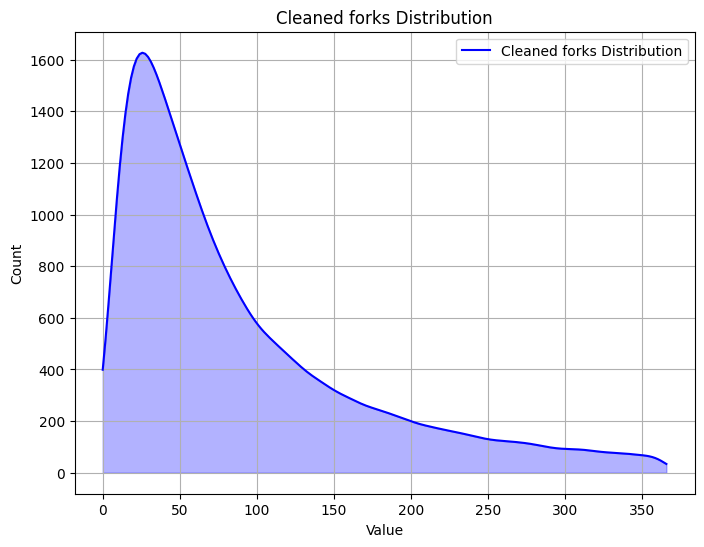

watchers


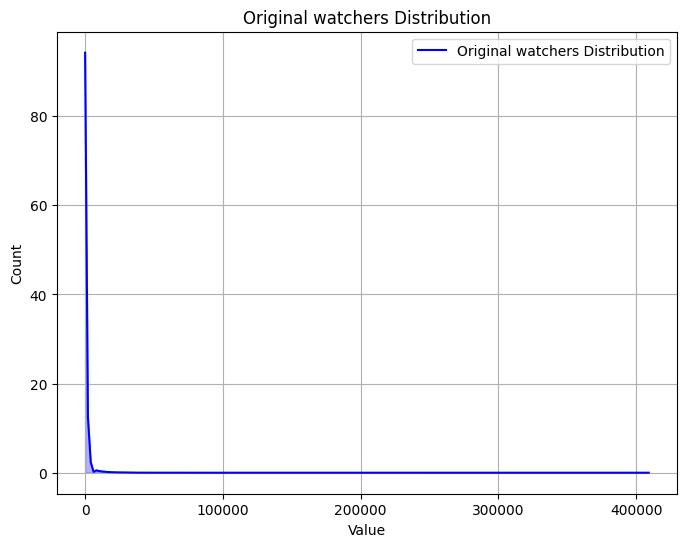

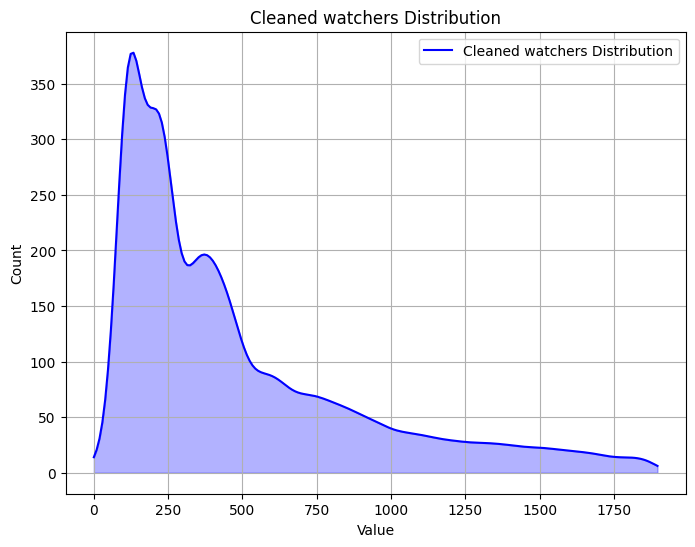

stars


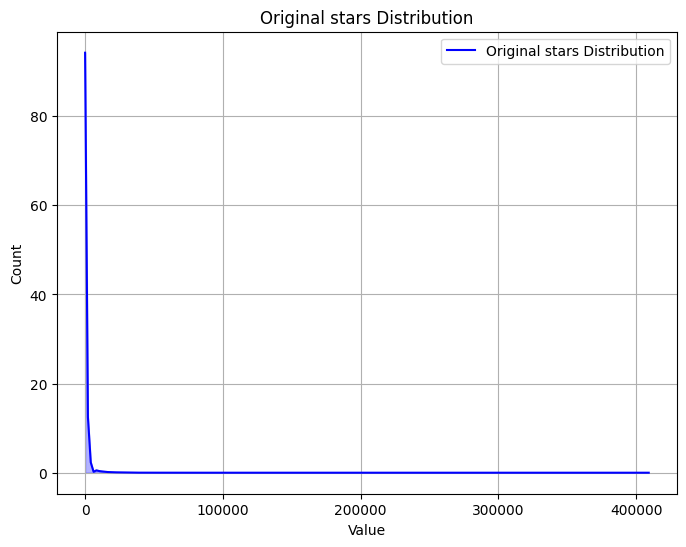

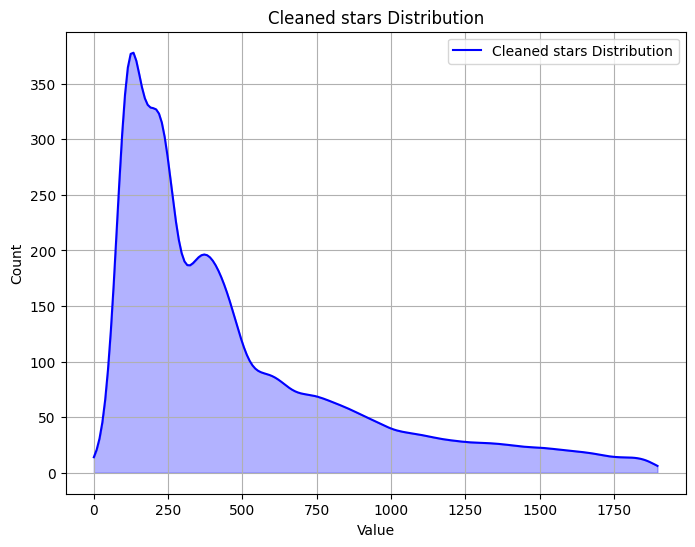

commits_freq


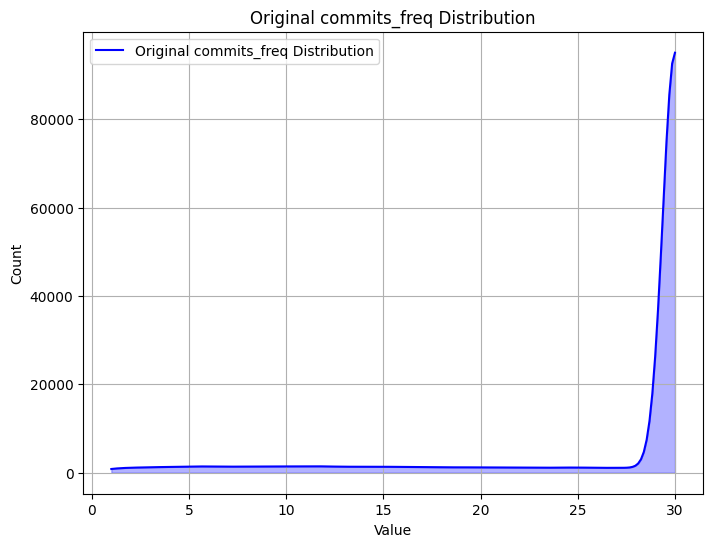

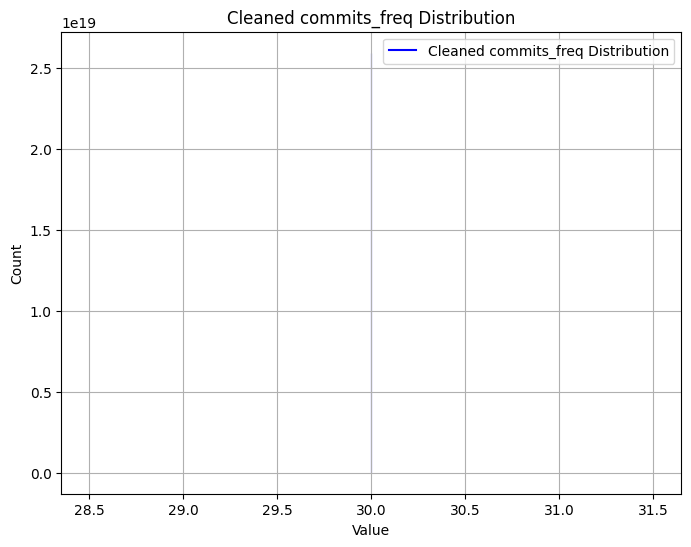

subscribers


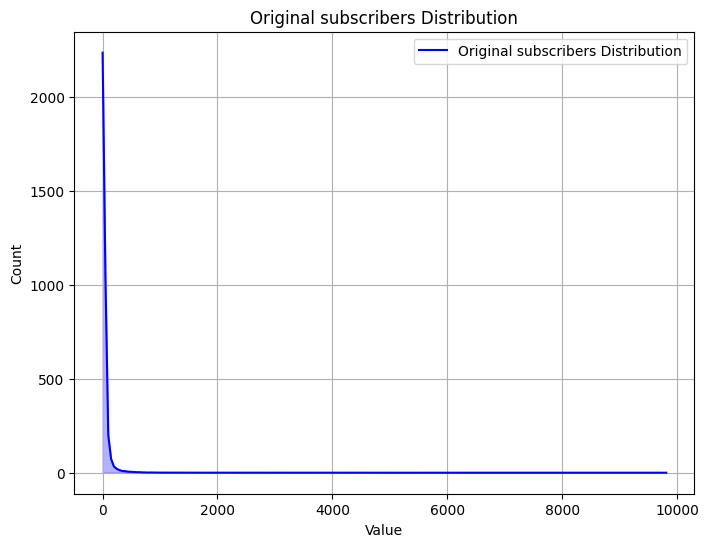

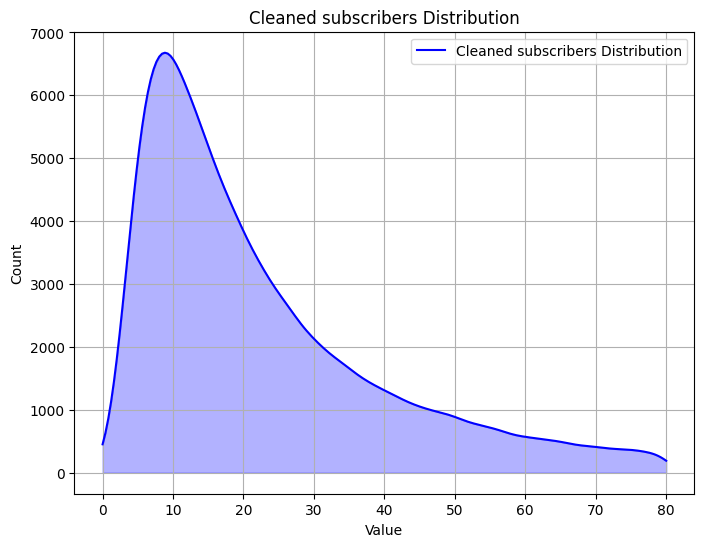

releases_freq


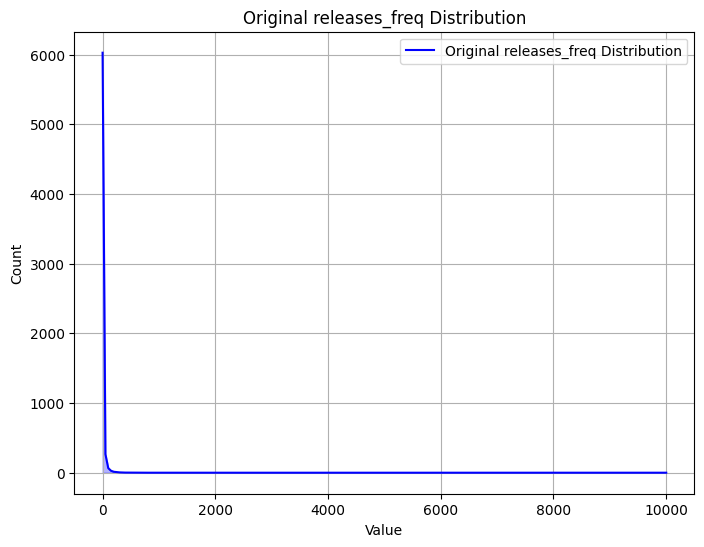

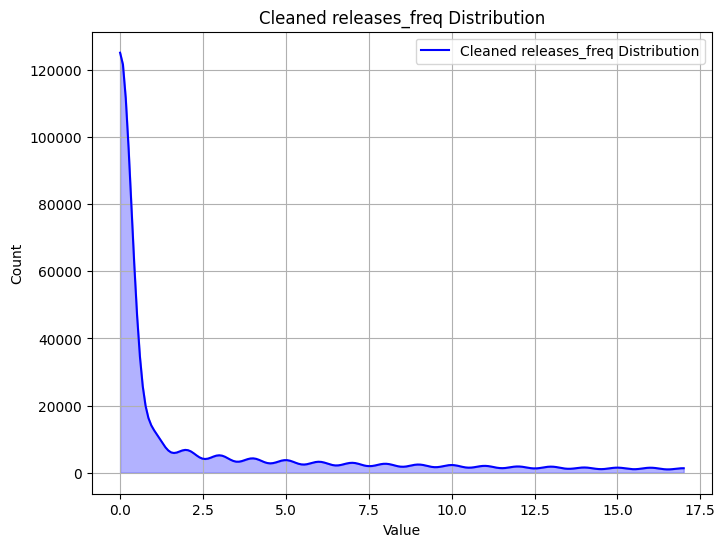

pull_requests


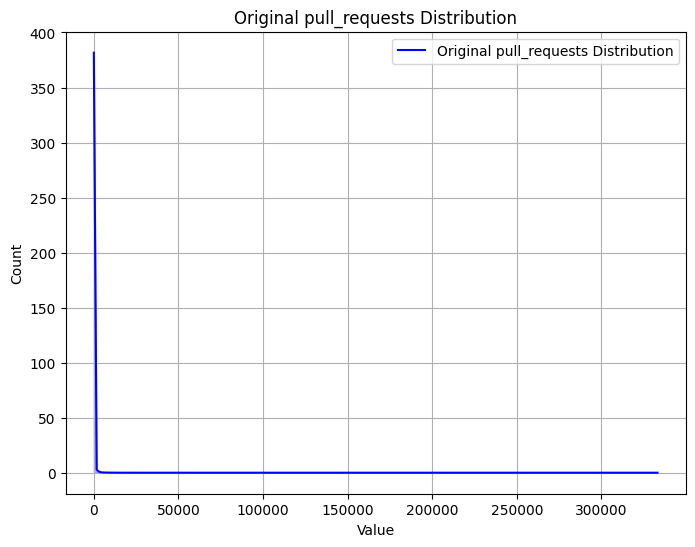

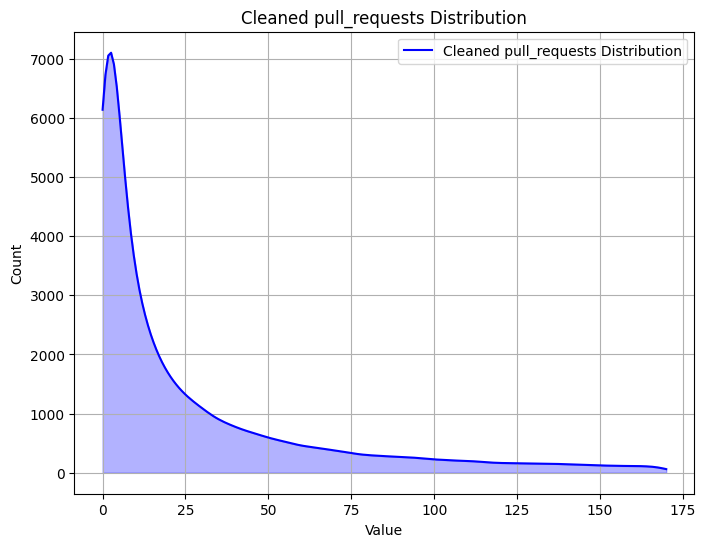

readme_size


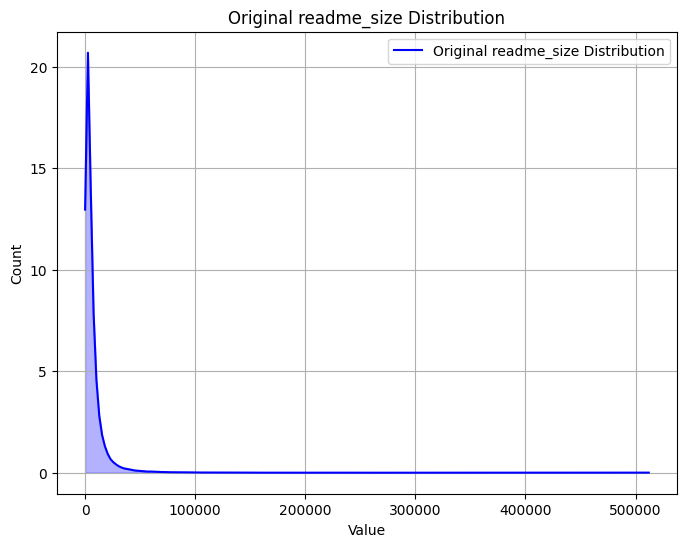

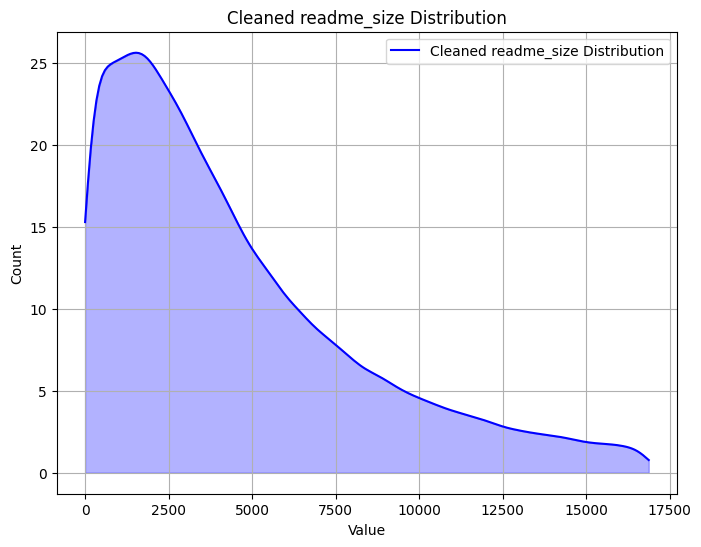

lines_of_codes


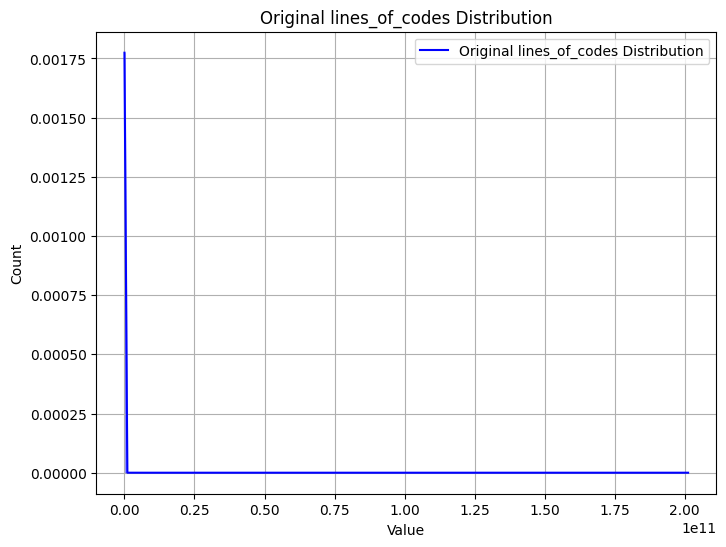

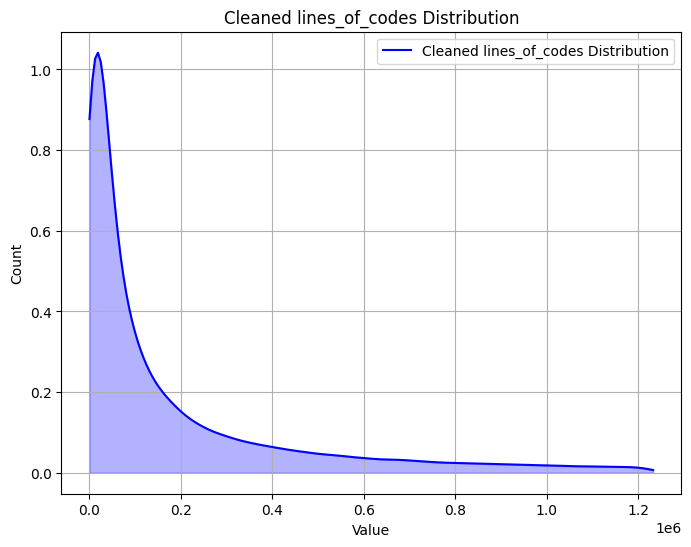

Original data size: 185876
Cleaned data size: 77030


In [9]:
df_cleaned, df = detect_and_remove_outliers(df, feature_columns=["forks", "watchers", "stars", "commits_freq", "subscribers",  "releases_freq",  "pull_requests",  "readme_size", "lines_of_codes"])
df[['watchers']].to_csv("file1.csv", index=False)
df_cleaned[['watchers']].to_csv("file2.csv", index=False)
df.to_csv('data_cleaned.csv', index=False)